# Calculating and Comparing Volatility Measures for a Stock

### Authors:
- Martynka Hirak
- Magdalena Szymkowiak

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import yfinance as yf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.stats import shapiro, normaltest
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')
sns.set_theme(style = 'darkgrid')

### Data Preparation

We chose the KGHM stock data for this project. We will consider data from the last 5 years.

In [2]:
start_date = "2020-01-01"
end_date = "2024-12-31"

In [3]:
kgh_stock = yf.Ticker('KGH.WA') 
h_data = kgh_stock.history(start=start_date, end=end_date, interval="1d", auto_adjust=False, actions=False)
h_data = h_data[['Close']]

h_data["Log_returns"] = np.log(h_data["Close"]/h_data["Close"].shift(1))
h_data = h_data.dropna()

In [5]:
h_data.head(5)

,Close,Log_returns
Date,,
2020-01-02 00:00:00+01:00,97.900002,0.023983
2020-01-03 00:00:00+01:00,96.120003,-0.018349
2020-01-06 00:00:00+01:00,96.120003,0.000000
2020-01-07 00:00:00+01:00,95.959999,-0.001666
2020-01-08 00:00:00+01:00,94.959999,-0.010476


Text(0.5, 0, 'Date')

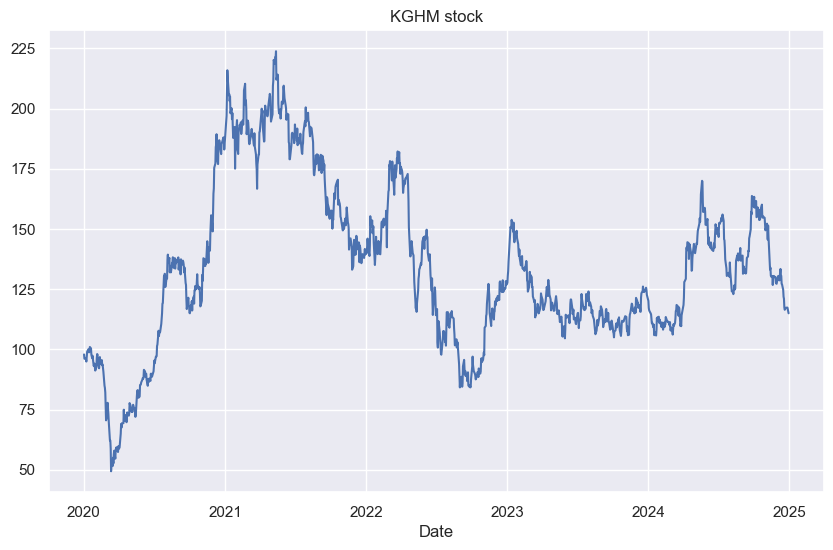

In [6]:
plt.figure(figsize=(10,6))
plt.plot(h_data['Close'])
plt.title("KGHM stock")
plt.xlabel('Date')

### Volatility Calculations

In [7]:
# historical volatility 
h_data['historical_volatility_30'] = h_data['Log_returns'].rolling(window=30).std()
h_data['historical_volatility_60'] = h_data['Log_returns'].rolling(window=60).std()

# annualized
h_data['h_vol_30_ann'] = h_data['historical_volatility_30']* np.sqrt(252)
h_data['h_vol_60_ann'] = h_data['historical_volatility_60']* np.sqrt(252)

In [8]:
#EWMA volatility
def ewma_variance(returns, decay_factor):
    weights = (1 - decay_factor) * (decay_factor ** np.arange(len(returns) - 1, -1, -1))
    ewma_variance = np.sum(weights * returns**2)
    return ewma_variance


decay_factor = 0.94 #lambda

h_data['EWMA_variance_30'] = h_data['Log_returns'].rolling(window=30).apply(lambda x: ewma_variance(x, decay_factor), raw=True)
h_data['EWMA_volatility_30'] = np.sqrt(h_data['EWMA_variance_30'])

h_data['EWMA_variance_60'] = h_data['Log_returns'].rolling(window=60).apply(lambda x: ewma_variance(x, decay_factor), raw=True)
h_data['EWMA_volatility_60'] = np.sqrt(h_data['EWMA_variance_60'])

h_data['EWMA_vol_30_ann'] = h_data['EWMA_volatility_30']*np.sqrt(252)
h_data['EWMA_vol_60_ann'] = h_data['EWMA_volatility_60']*np.sqrt(252)

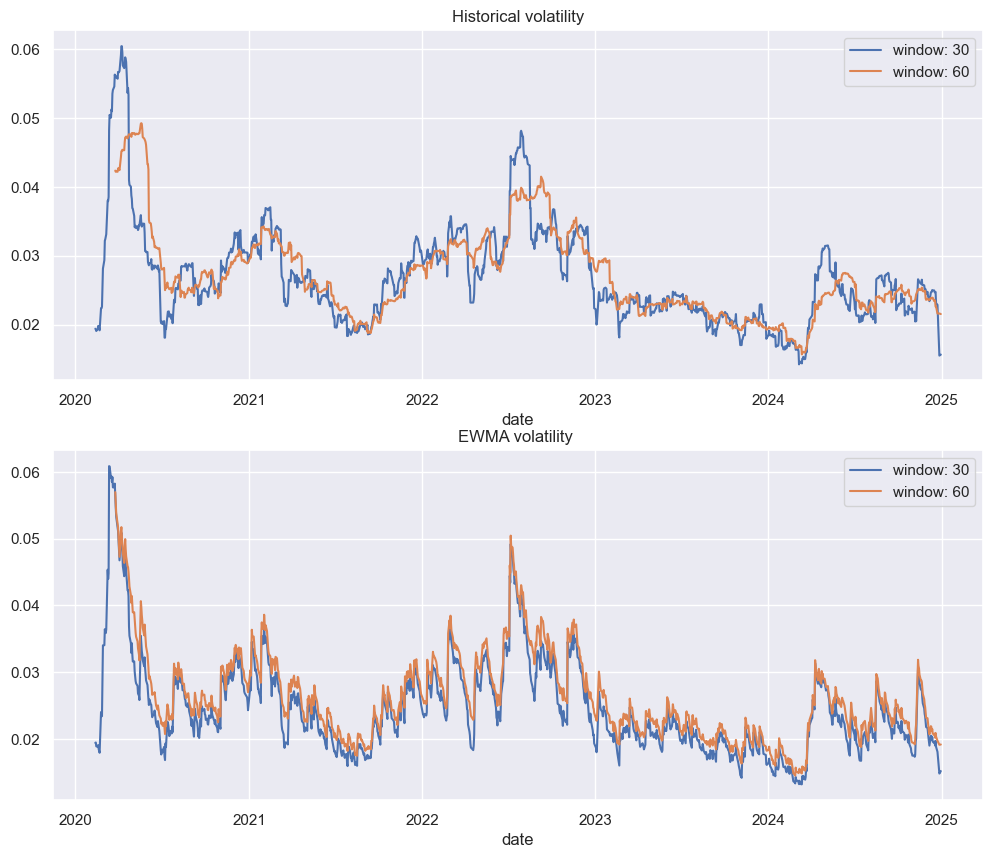

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(12,10))
axs[0].plot(h_data['historical_volatility_30'], label = 'window: 30')
axs[0].plot(h_data['historical_volatility_60'], label = 'window: 60')
axs[0].set_title('Historical volatility')
axs[0].set_xlabel('Date')
axs[0].legend()

axs[1].plot(h_data['EWMA_volatility_30'], label = 'window: 30')
axs[1].plot(h_data['EWMA_volatility_60'], label = 'window: 60')
plt.title('EWMA volatility ')
plt.xlabel('Date')
plt.legend()

On the charts above we can see two types of volatility measures which are simple historical EWMA. Both measures were calculated using window size of 30 and 60 observations. We can observe that for historical measure the calculated volatility with window 30 is more sensitive to market changes and captures better short-term dynamics. Whereas historical volatility with window 60 has less information and thus is smoother. Moreover, the volatilities calculated with larger window are slightly shited to the right. This shift disappear in the EWMA volatilities. This is because each observation (return) in the window has different weight which is bigger for more recent data and lower for older, this way the very recent return have the most influence in calcualtions. The EWMA volatility is almost the same in the shape for both sizes of windows and we can only observe that for window 60 volatilities are slightly higher than for smaller window.

From practical point of view, shorter window is suitable for high-frequency trading or short-term strategies. Whereas larger window is better for medium and long-term risk managment portfolio rebalancing.

### GARCH model

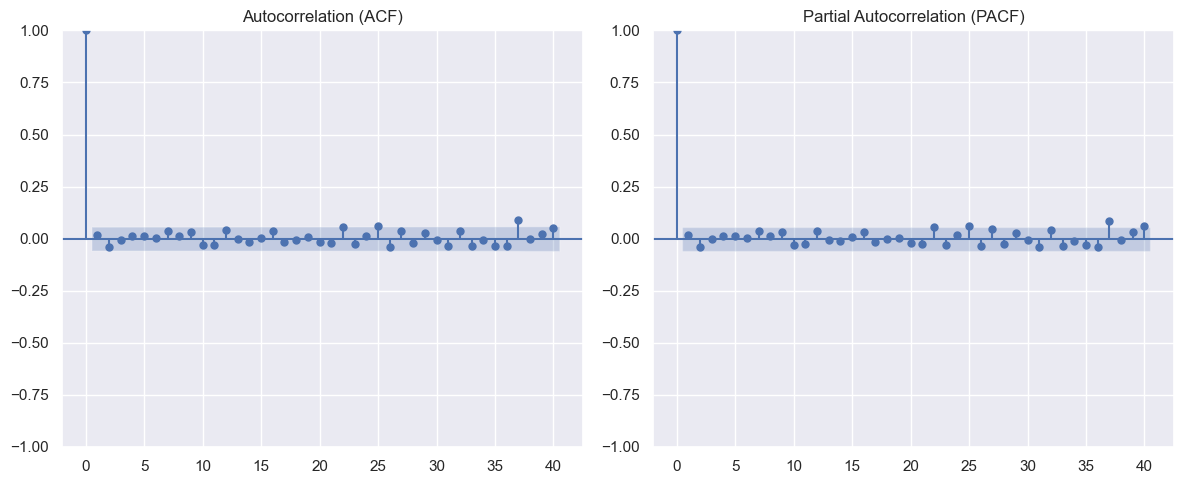

In [ ]:
returns = h_data['Log_returns'].dropna()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))

plot_acf(returns, lags=40, ax=ax1)
plot_pacf(returns, lags=40, ax=ax2)
ax1.set_title("Autocorrelation (ACF)")
ax2.set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

We can see that our time series is not correlated.

In [11]:
p_range = range(1, 4) 
q_range = range(1, 4)  

best_aic = np.inf 
best_order = None
best_model = None

for p in p_range:
    for q in q_range:
        try:
            model = arch_model(h_data['Log_returns'], vol='Garch', p=p, q=q)
            results = model.fit(disp='off')
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, q)
                best_model = results
        except Exception as e:
            print(f"Error with GARCH({p},{q}): {e}")

print(f"Best Model: GARCH{best_order}, AIC: {best_aic}, BIC: {results.bic}")

Best Model: GARCH(1, 1), AIC: -5515.754077626526, BIC: -5468.464350813209


From all combinations of p's and q's in range [1,3], the best model is *GARCH(1,1)*.

In [12]:
mean_return = np.mean(h_data['Log_returns'])
adf_test = sm.tsa.adfuller(h_data['Log_returns'])
mean_return, adf_test[1] # p-value < 0.05 so series are stationary

(np.float64(0.00014691701037008407), 0.0)

Now, we check the stationarity of our returns. The p-value of the ADF test is less than significance level of 0.05 and thus we reject the null hypothesis, which means that the series are stationary.

In [13]:
returns_data = h_data['Log_returns']
model = arch_model(returns_data, vol='Garch', p=1, q=1, mean='Zero', dist='Normal')
fitted_model = model.fit(disp='off')

residuals = fitted_model.resid

#test for normality
stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test: stat={stat}, p={p_value}")
stat, p_value = normaltest(residuals)
print(f"D’Agostino and Pearson’s test: stat={stat}, p={p_value}")

Shapiro-Wilk test: stat=0.9770011221899436, p=2.8125714505748454e-13
D’Agostino and Pearson’s test: stat=78.72867642558613, p=8.022045675407752e-18


The p-value from both normality test are less than the significance level (0.05) which means that we reject null hypothesis. The residuas of the returns are non-normally distributed. That's why we will check if maybe *t-student* distribution be better for our model.

In [15]:
model_zero_normal = arch_model(returns_data, vol='Garch', p=1, q=1, mean='Zero', dist='normal').fit(disp="off")
model_zero_student = arch_model(returns_data, vol='Garch', p=1, q=1, mean='Zero', dist='studentst').fit(disp="off")

# Compare AIC and BIC
print("Model Comparison:")
print(f"Zero-Normal: AIC={model_zero_normal.aic}, BIC={model_zero_normal.bic}")
print(f"Zero-Student: AIC={model_zero_student.aic}, BIC={model_zero_student.bic}")

Model Comparison:
Zero-Normal: AIC=-5518.855536385891, BIC=-5503.4413172837585
Zero-Student: AIC=-5563.840535517684, BIC=-5543.288243381507


We can see that both AIC and BIC are lower for second model, that's why we will chose this one for fitting the model and forecasting volatility.

In [16]:
# GARCH fitting
returns = h_data['Log_returns'].dropna() * 100  # scale returns to percentage
model = arch_model(returns, vol='Garch', p=1, q=1,mean = 'Zero', dist = 'studentst')
garch_fit = model.fit(disp="off")

h_data['GARCH_volatility'] =garch_fit.conditional_volatility/100
h_data['GARCH_volatility_ann'] = h_data['GARCH_volatility'] * np.sqrt(252)

In [23]:
#realized volatility
rt_sq = (h_data['Log_returns'])**2

window_size = 30
h_data["realized_volatility"]= rt_sq.rolling(window=30).sum().apply(np.sqrt)/np.sqrt(30)

For evaluating how well measures are calculated we will use *realized volatility* which is aggregation of squared returns over a window of time.

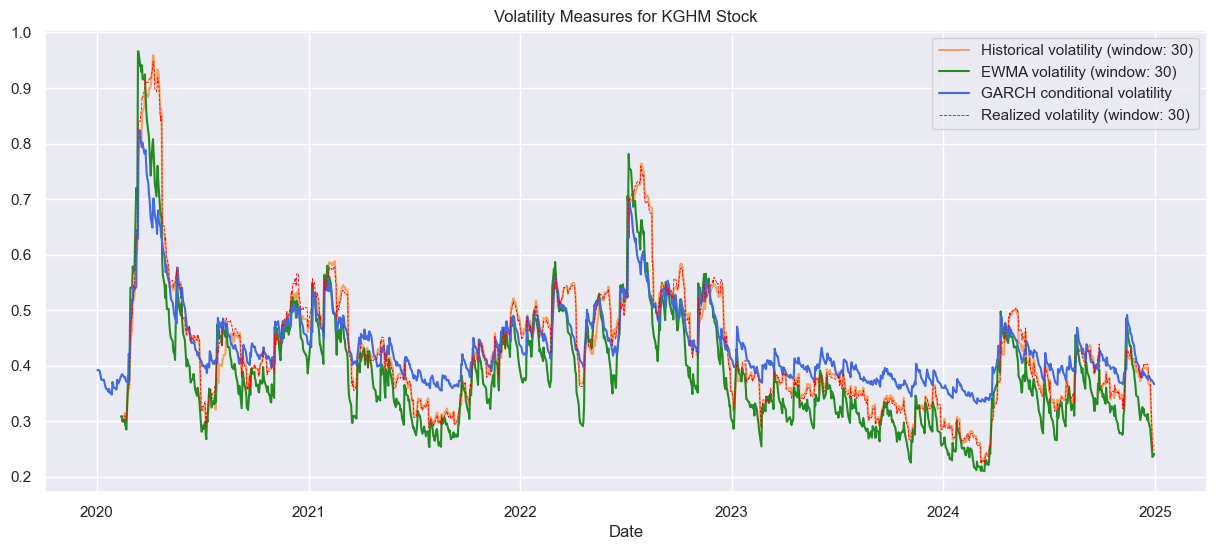

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(h_data['h_vol_30_ann'], label = 'Historical volatility (window: 30)', color = 'sandybrown')
plt.plot(h_data['EWMA_vol_30_ann'], label = 'EWMA volatility (window: 30)', color = 'forestgreen')
plt.plot(h_data['GARCH_volatility_ann'], label = 'GARCH conditional volatility', color = 'royalblue')
plt.plot(h_data.index,h_data["realized_volatility"]*np.sqrt(252),"--", linewidth = 0.6  ,label = 'Realized volatility (window: 30)', color = 'red')
plt.title('Volatility Measures for KGHM Stock')
plt.xlabel('Date')
plt.legend()

On the plot above, we have all calculated measures which results were annualized for comparing purposes. We can see that volatilities gotten form the GARCH model is not that sensitive as historical volatilities. Here we should point out that on this plot GARCH model is not predicting any values, the model was only fitted. 

EMWA volatilies are sharper and are more sensitive to market changes.

Generally, historical volatility tends to lag behind the sudden changes in the market. It averages the past returns without weighting heavily on the recent data. EWMA is more responsive to sudden price movements, thanks to its exponential weights. This makes EWMA quicker to capture market volatility spikes or declines, often reflecting these changes within a day or two. GARCH models are dynamic and predictive, incorporating past variances and residuals to estimate current volatility. Unlike EWMA, which responds instantly, GARCH models reflect a gradual adjustment to new conditions as the volatility process reverts to its mean over time.

Historical volatility is useful in scenarios with less frequent trading or when historical performance needs to be compared across assets. EWMA is great for traders and risk managers requiring fast adjustments to current market conditions and commonly used in Value-at-Risk calculations. Whereas GARCH models are widely used in derivatives pricing, particularly for options, where accurate volatility forecasts are important.



In [30]:
#GARCH forecasting
train_size = int(0.8 * len(returns)) 
train_returns = returns[:train_size]
test_returns = returns[train_size:] 

model2 = arch_model(train_returns, vol='Garch', p=1, q=1, mean = 'Zero', dist = 'studentst')
garch_fit2 = model2.fit(disp="off")

forecast = garch_fit2.forecast(horizon=len(test_returns), reindex=False)
test_volatility = forecast.variance.values[-1:] ** 0.5 

forecasted_volatility = np.sqrt(forecast.variance.values[-len(test_returns):])/100

train_annualized_volatility = garch_fit2.conditional_volatility/100 * np.sqrt(252)
test_annualized_volatility = forecasted_volatility * np.sqrt(252)

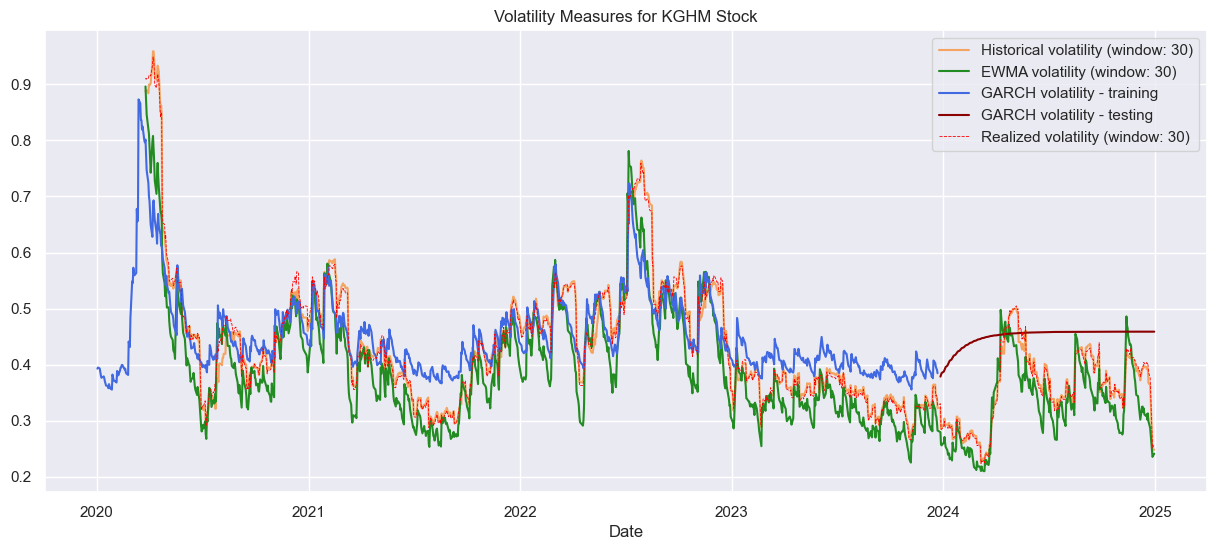

In [61]:
plt.figure(figsize=(15, 6))
plt.plot(h_data['h_vol_30_ann'], label = 'Historical volatility (window: 30)', color = 'sandybrown')
plt.plot(h_data['EWMA_vol_30_ann'], label = 'EWMA volatility (window: 30)', color = 'forestgreen')
plt.plot(train_returns.index, train_annualized_volatility, label="GARCH volatility - training", color = 'royalblue')
plt.plot(test_returns.index, test_annualized_volatility.reshape(len(test_returns),1), label="GARCH volatility - testing", color="darkred")
plt.plot(h_data.index,h_data["realized_volatility"]*np.sqrt(252),"--", linewidth = 0.6  ,label = 'Realized volatility (window: 30)', color = 'red')
plt.title('Volatility Measures for KGHM Stock')
plt.xlabel('Date')
plt.legend()

On the chart above we have almost the same results apart from the GARCH model. This model was used on training and testing dataset. The burgundy color shows the forecasting values of volatility. 

### Metrics

In [49]:
h_data = h_data.dropna()
measures_names = ['h_vol_30_ann','h_vol_60_ann','EWMA_vol_30_ann', 'EWMA_vol_60_ann','GARCH_volatility_ann']
rmse_tab = []
for name in measures_names:
    rmse_tab.append(np.sqrt(mean_squared_error(h_data['realized_volatility']*np.sqrt(252), h_data[name])))

In [55]:
for i in range(len(rmse_tab)):
    print(f"RMSE for {measures_names[i]}:", rmse_tab[i])

RMSE for h_vol_30_ann: 0.010138750336856385
RMSE for h_vol_60_ann: 0.06142190418255149
RMSE for EWMA_vol_30_ann: 0.05300688900069873
RMSE for EWMA_vol_60_ann: 0.037954235155641045
RMSE for GARCH_volatility_ann: 0.056649118365676786


We can see that the lowest RMSE is for historical volatility with window size of 30 observations. This can indicate the best results, however because of the way the realized volatility was calculated, we could expect such a results. That's why we will also calculate the RMSE between these measures and squarted log-returns.

In [57]:
h_data = h_data.dropna()
measures_names = ['h_vol_30_ann','h_vol_60_ann','EWMA_vol_30_ann', 'EWMA_vol_60_ann','GARCH_volatility_ann']
rmse_tab2 = []
rt_sq = h_data['Log_returns']**2
for name in measures_names:
    rmse_tab2.append(np.sqrt(mean_squared_error(h_data['Log_returns']**2, h_data[name]**2)))

In [59]:
for i in range(len(rmse_tab2)):
    print(f"RMSE for {measures_names[i]}:", rmse_tab2[i])

RMSE for h_vol_30_ann: 0.22659848809882013
RMSE for h_vol_60_ann: 0.22042431518085237
RMSE for EWMA_vol_30_ann: 0.1868854101571768
RMSE for EWMA_vol_60_ann: 0.21339774631382274
RMSE for GARCH_volatility_ann: 0.2041703056000464


Now, the best result is for EWMA with window size 30 obserwations which is more reasonable.